<a href="https://colab.research.google.com/github/Plixelated/sky_transparency_model_testing/blob/main/Transparency_Models_(Clean).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data Pre-Processing**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
seed = 42

In [ ]:
df = pd.read_csv('/content/transparency_model_dataset.csv')

In [ ]:
drop_columns = ['transparency_forecast (0-5)','time','seeing_forecast (0-5)','seeing_forecast_age (hrs)', 'transparency_forecast_age (hrs)']

Set Attributes and Target Datasets

In [ ]:
attributes = df.drop(columns=drop_columns)
target = df["transparency_forecast (0-5)"]

###Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
attributes_normal = scaler.fit_transform(attributes.values)

###Principle Component Analysis

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = 10)
attributes_pca = pca.fit_transform(attributes_normal)

In [ ]:
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Values:",explained_variance)
print('Total Dataset Retained:',sum(explained_variance))

Explained Variance Values: [0.35944801 0.13752239 0.09267335 0.05602033 0.05050156 0.04527213
 0.02777496 0.02685713 0.02423632 0.01622504]
Total Dataset Retained: 0.8365312065549084


###Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from matplotlib.ticker import PercentFormatter

In [ ]:
#@title Non-PCA Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    attributes_normal, target.values, test_size=0.3, stratify=target.values, random_state=seed)

In [ ]:
#@title PCA Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    attributes_pca, target.values, test_size=0.3, stratify=target.values, random_state=seed)

###Resampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
oversampler = RandomOverSampler(random_state=seed)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

###Supplementary methods

In [ ]:
#@title Kfold Validation Method

def kfold_validate(k,model,X1,X2,y1,y2):
  _kf = KFold(n_splits = k)
  _model_f1_CV_list = []
  _model_f1_test_list = []
  _models = []

  for train_index, test_index in _kf.split(X1):
      X_train_CV, X_test_CV = X1[train_index], X1[test_index]
      y_train_CV, y_test_CV = y1[train_index], y1[test_index]
      model.fit(X_train_CV, y_train_CV)
      _models.append(model)

      #Target prediction & F1 score using the 10 rows left out from CV.
      y_pred_CV = model.predict(X_test_CV)
      _model_f1_CV = f1_score(y_test_CV, y_pred_CV, average='weighted')
      _model_f1_CV_list.append(_model_f1_CV)

      #Target prediction & F1 score using the rows from your test split.
      y_pred_test = model.predict(X2)
      _model_f1_test = f1_score(y2, y_pred_test,average='weighted')
      _model_f1_test_list.append(_model_f1_test)

  return _model_f1_test_list, _models

In [ ]:
#@title Model Accuracy Table and Kfold Avg Methods

def get_accuracy_table(y_t,y_p):
  print('Accuracy: ', metrics.accuracy_score(y_t, y_p) * 100)
  print(classification_report(y_t,y_p,labels=np.unique(y_p)))

def get_kfold_avg(test_results):
  return sum(test_results)/len(test_results)

def plot_kfold_avg(test_results):
  x = [i for i in range(len(test_results))]
  y = test_results
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
  plt.ylim(0.9,1.0)
  plt.bar(x,y,width = 0.75)
  plt.xlabel("Fold")
  plt.ylabel("F1 Score")
  plt.show()

In [ ]:
#@title Save/Load Models and Results

import pickle

def save_model(model_name,model):
  filename = f'{model_name}_{int(metrics.accuracy_score(y_test, y_pred) * 100)}'
  with open(f"{filename}.pkl", "wb") as f:
      pickle.dump(model, f)

def save_kfold_results(results,filename):
  # Save the list to a file
  with open(f"{filename}.pkl", "wb") as f:
      pickle.dump(results, f)

def save_kfold_models(model_list,model_name):
  with open(f'{model_name}_models.pkl', 'wb') as f:
    pickle.dump(model_list, f)

def load_model(filename):
  loaded_model = pickle.load(open(f'{filename}', 'rb'))
  return loaded_model

def load_kfold_results(filename):
  # Load the list from the file
  with open(f"{filename}.pkl", "rb") as f:
      loaded_list = pickle.load(f)
      return loaded_list

def load_kfold_models(filename):
 with open(f'{filename}.pkl', 'rb') as f:
    loaded_models = pickle.load(f)
    return loaded_models

In [ ]:
#@title Import Models, Tree Visualization, and K-Fold CV from Sklearn

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualization
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

#K-Fold Cross Validation
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

import time

#**Random Forest**

##**Random Forest Training**

In [ ]:
#Create RFC Model with Select Hyperparameters
rfc = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,max_features='sqrt',
    n_estimators=300,
    random_state=seed)
rfc

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=300,
                       random_state=42)

###**K-Fold Cross Validation**

In [ ]:
#K Fold Validation Training
start_time = time.time()
k_fold_rfc,rfc_models = kfold_validate(10,rfc,X_train,X_test,y_train,y_test)
#Get End Time
end_time = time.time()
#Get Total Training Time
training_time = end_time - start_time
print('Training Time:',training_time)
k_fold_rfc

Training Time: 63.55494976043701


[0.5369521349956848,
 0.5335874601016035,
 0.53290843487026,
 0.5327515119185722,
 0.5281357639898706,
 0.5315367207334154,
 0.5336579437818646,
 0.5294115154428739,
 0.5361182795688778,
 0.5400836389193759]

In [ ]:
#Show Averaged Accuracy of Kfold Models
get_kfold_avg(k_fold_rfc)

0.5335143404322399

###**Train Model**

In [ ]:
#Train Single Model on entire Dataset

#Get Start Time
start_time = time.time()
#Train Model
rfc.fit(X_train,y_train)
#Get End Time
end_time = time.time()
#Get Total Training Time
training_time = end_time - start_time
training_time

5.807288646697998

###**Model Validation**

**Predicitions**

In [ ]:
#Get Predicted Values
y_pred = rfc.predict(X_test)

In [ ]:
#Display Accuracy Table Based on Predicted Values
get_accuracy_table(y_test,y_pred)

Accuracy:  53.36749633967789
              precision    recall  f1-score   support

           0       0.80      0.59      0.68       560
           1       0.21      0.48      0.29       126
           2       0.34      0.30      0.32       363
           3       0.48      0.25      0.32       451
           4       0.45      0.49      0.47       551
           5       0.66      0.84      0.74       681

    accuracy                           0.53      2732
   macro avg       0.49      0.49      0.47      2732
weighted avg       0.55      0.53      0.53      2732



In [ ]:
#Get F1 Score for each class
f1 = metrics.f1_score(y_test,y_pred,average=None)
f1

array([0.67761807, 0.29256595, 0.31884058, 0.3245614 , 0.47007806,
       0.74385511])

##**RFC Visualizations**

**F1 Score Per Target Class**

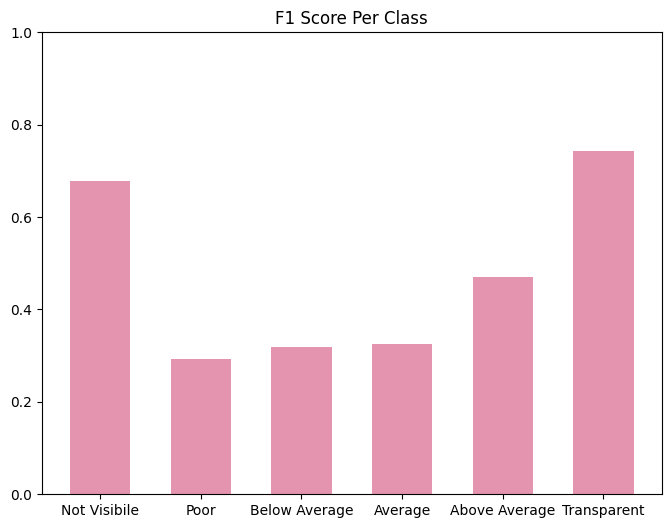

In [ ]:
#Fig 13
plt.figure(figsize=(8,6))
classes=["Not Visibile","Poor","Below Average","Average","Above Average","Transparent"]
plt.bar(classes,f1,width=0.6,color='palevioletred',alpha=0.75)
plt.ylim(0,1)
plt.title("F1 Score Per Class")
plt.show()

**K-Fold Models vs Full Dataset Visualization**

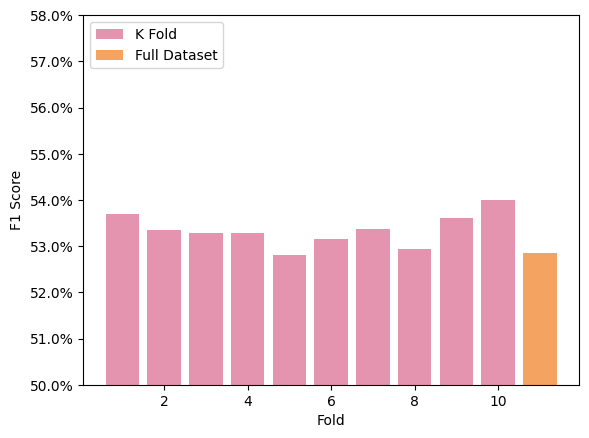

In [ ]:
#Fig 12
x = [i+1 for i in range(len(k_fold_rfc))]
y = k_fold_rfc
f1 = f1_score(y_test,y_pred,average="weighted")

fig, ax=plt.subplots()

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylim(0.5,0.58)

ax.bar(x,y,label='K Fold',color='palevioletred',alpha=0.75)
ax.bar(11,f1,label='Full Dataset',color='sandybrown')

plt.legend(loc='upper left')


plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.show()

**Confusion Matrix**

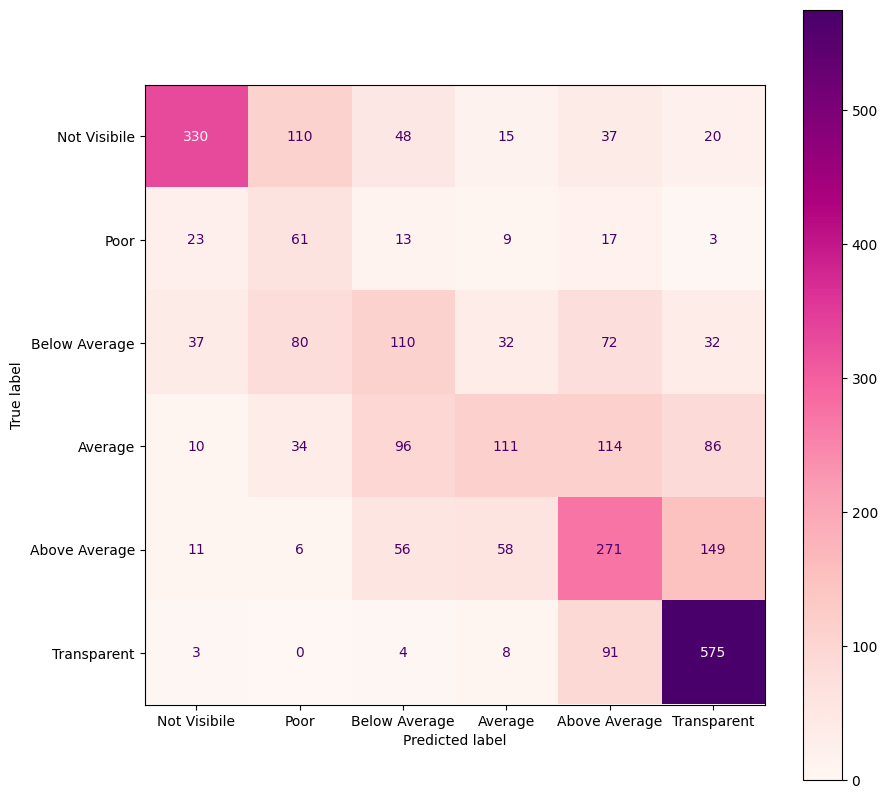

In [ ]:
#FIG 14
# Create the confusion matrix
labels = ["Not Visibile","Poor","Below Average","Average","Above Average","Transparent"]
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax,cmap='RdPu')
plt.show()

#**Gradient Boosting**

##**Gradient Boosting Training**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
#Create Gradient Boosting Model with Hyperparameters
gradient_booster = GradientBoostingClassifier(
    n_estimators=1000,
    max_depth = 5,
    random_state = seed,
    learning_rate=0.1,
    validation_fraction=0.1,
    n_iter_no_change=10,
    min_samples_split=50,
    min_samples_leaf=50)
gradient_booster.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 50,
 'min_samples_split': 50,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_iter_no_change': 10,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

###**K-Fold Cross Validation**

In [ ]:
#Kfold Validation Training
start_time = time.time()
k_fold_gradient, gradient_models = kfold_validate(10,gradient_booster,X_train,X_test,y_train,y_test)
#Get End Time
end_time = time.time()
#Get Total Training Time
training_time = end_time - start_time
print("Training Time:",training_time)
k_fold_gradient

Training Time: 1597.4097504615784


[0.6516738497037216,
 0.653908947570096,
 0.6450858767598531,
 0.6573527929131758,
 0.6560092765575211,
 0.6451488625159847,
 0.6520897974380329,
 0.6610739028213501,
 0.6606048254515241,
 0.6454774839071873]

In [ ]:
#Get Average Accuracy of KFold Models
get_kfold_avg(k_fold_gradient)

0.6528425615638447

###**Train Model**

In [ ]:
#Train Single Model on Full Dataset
#Get Start Time
start_time = time.time()
#Train Model
gradient_booster.fit(X_train,y_train)
#Get End Time
end_time = time.time()
#Get Total Training Time
training_time = end_time - start_time
training_time

223.3556580543518

In [ ]:
#Get Number of Iterations
gradient_booster.n_estimators_

578

###**Model Validation**

**Make Predictions**

In [ ]:
#Get Predicted Values
y_pred = gradient_booster.predict(X_test)

In [ ]:
#Get Validation Table
get_accuracy_table(y_test,y_pred)

Accuracy:  65.70278184480233
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       560
           1       0.34      0.22      0.27       126
           2       0.44      0.39      0.41       363
           3       0.56      0.53      0.55       451
           4       0.61      0.67      0.64       551
           5       0.84      0.85      0.84       681

    accuracy                           0.66      2732
   macro avg       0.59      0.57      0.58      2732
weighted avg       0.65      0.66      0.65      2732



##**GB Visualizations**

**K-Fold Models vs Full Dataset**

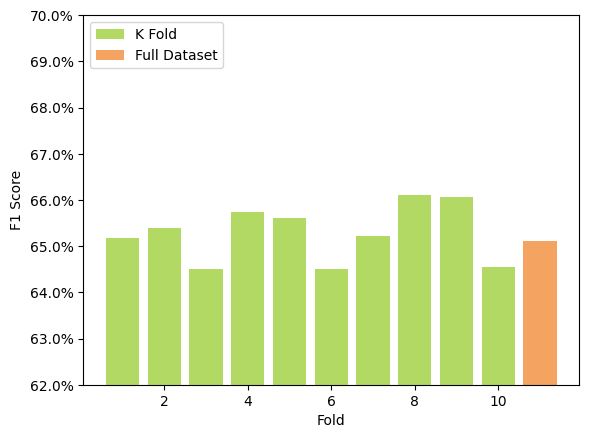

In [ ]:
x = [i+1 for i in range(len(k_fold_rfc))]
y = k_fold_gradient
f1 = f1_score(y_test,y_pred,average="weighted")

fig, ax=plt.subplots()

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylim(0.62,0.70)

ax.bar(x,y,label='K Fold',color='yellowgreen',alpha=0.75)
ax.bar(11,f1,label='Full Dataset',color='sandybrown')

plt.legend(loc='upper left')


plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.show()

**Confusion Matrix**

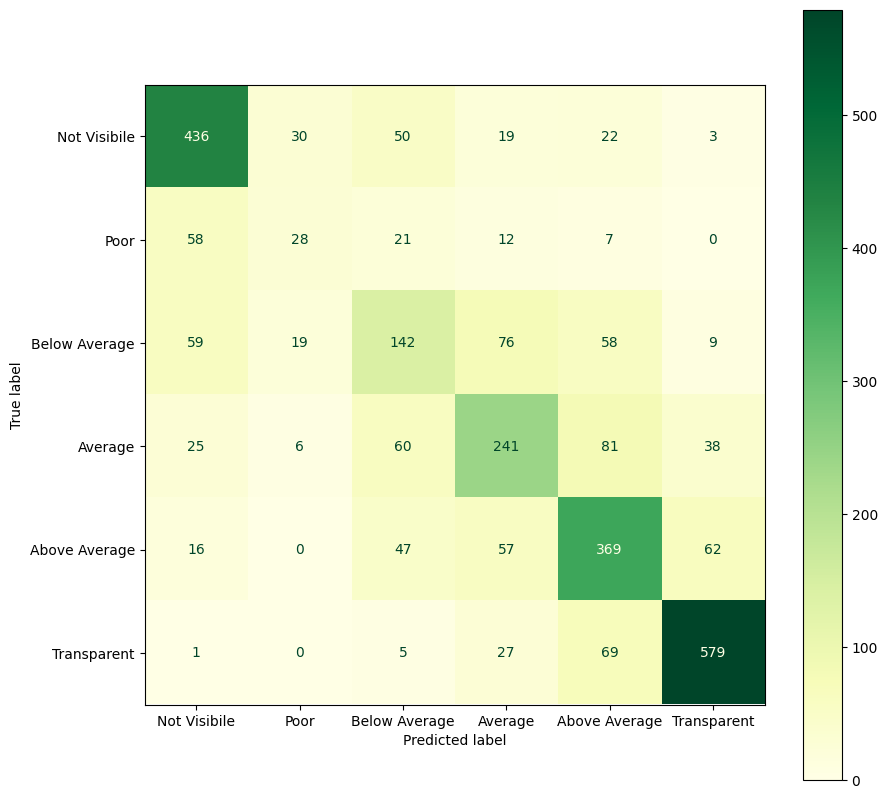

In [ ]:
# Create the confusion matrix
labels = ["Not Visibile","Poor","Below Average","Average","Above Average","Transparent"]
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax,cmap="YlGn")
plt.show()

**Accuracy Per Iterator Visualization**

In [ ]:
accuracy_growth = []
for y_pred in gradient_booster.staged_predict(X_test):
    accuracy_growth.append(metrics.accuracy_score(y_test, y_pred))

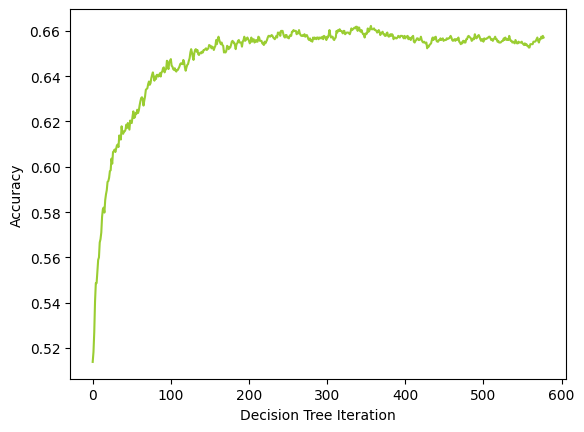

In [ ]:
plt.plot(accuracy_growth,color="yellowgreen")
plt.ylabel("Accuracy")
plt.xlabel("Decision Tree Iteration")
plt.show()

#**Multilayer Perceptron**

##**Grid Search**

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(256,128,64),(128,64,32), (73,32,6),],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init': [0.001, 0.0001]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    solver='adam',
    max_iter=1000,
    early_stopping = True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=seed
    )
mlp
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

In [ ]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

##**MLP Training**

In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    solver='adam',
    max_iter=1000,
    early_stopping = True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=seed
    )
mlp

MLPClassifier(early_stopping=True, hidden_layer_sizes=(256, 128, 64),
              max_iter=1000, random_state=42)

In [ ]:
#Reset Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    attributes_normal, target.values, test_size=0.3, stratify=target.values, random_state=seed)
oversampler = RandomOverSampler(random_state=seed)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

###**K-Fold Validation**

In [ ]:
#Kfold Validation Training
start_time = time.time()
k_fold_mlp, mlp_models = kfold_validate(10,mlp,X_train,X_test,y_train,y_test)
#Get End Time
end_time = time.time()
#Get Total Training Time
training_time = end_time - start_time
print("Training Time:",training_time)
k_fold_mlp

In [ ]:
#Get Average Accuracy of KFold Models
get_kfold_avg(k_fold_mlp)

In [ ]:
#Get Number of Epochs per K-Fold Model
for i in range(len(mlp_models)):
  print(mlp_models[i].n_iter_)

###**Train Model**

In [ ]:
#Get Start Time
start_time = time.time()
#Train Model
mlp.fit(X_train, y_train)
#Get End Time
end_time = time.time()
#Get Total Training Time
training_time = end_time - start_time
print("Training Time:",training_time)
#Show Number of Iterations
print(mlp.n_iter_)

Training Time: 40.63346743583679
121


###**Model Validation**

**Make Predictions**

In [ ]:
y_pred = mlp.predict(X_test)

In [ ]:
get_accuracy_table(y_test,y_pred)

Accuracy:  70.5710102489019
              precision    recall  f1-score   support

           0       0.74      0.79      0.77       560
           1       0.30      0.33      0.32       126
           2       0.54      0.49      0.51       363
           3       0.67      0.60      0.64       451
           4       0.69      0.71      0.70       551
           5       0.87      0.88      0.87       681

    accuracy                           0.71      2732
   macro avg       0.64      0.64      0.63      2732
weighted avg       0.70      0.71      0.70      2732



##**MLP Visualizations**

Recreate Model with Optimized hyperparamaters for visualization

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_vis = MLPClassifier(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    solver='adam',
    max_iter=1000,
    early_stopping = False,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=seed
    )
mlp_vis

MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=1000, random_state=42)

Create list of scores and epochs and run a partial fit to track values across each epoch

In [ ]:
scores = []
epochs = []
#Run partial fit to match number of iterations in original MLP Model
#This is neccessary because early stopping is not available in partial fitting
for epoch in range(mlp.n_iter_):
  mlp_vis.partial_fit(X_train,y_train,classes=y_train)
  scores.append(mlp_vis.score(X_test,y_test))
  epochs.append(epoch)

**Make Prediction**

In [ ]:
y_pred_vis = mlp_vis.predict(X_test)

Verify Similiar Accuracy to Original Model

In [ ]:
get_accuracy_table(y_test,y_pred_vis)

Accuracy:  69.94875549048317
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       560
           1       0.33      0.21      0.25       126
           2       0.52      0.48      0.50       363
           3       0.62      0.66      0.64       451
           4       0.66      0.71      0.69       551
           5       0.87      0.89      0.88       681

    accuracy                           0.70      2732
   macro avg       0.63      0.61      0.62      2732
weighted avg       0.69      0.70      0.69      2732



**Accuracy Per Epoch**

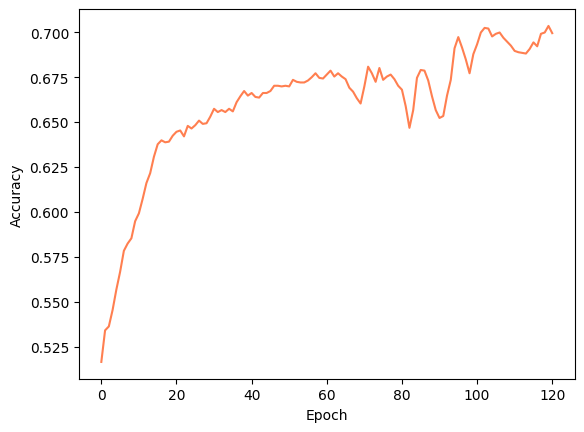

In [ ]:
#Fig 19
plt.plot(scores,color="coral")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

**K-Fold vs Full Dataset**

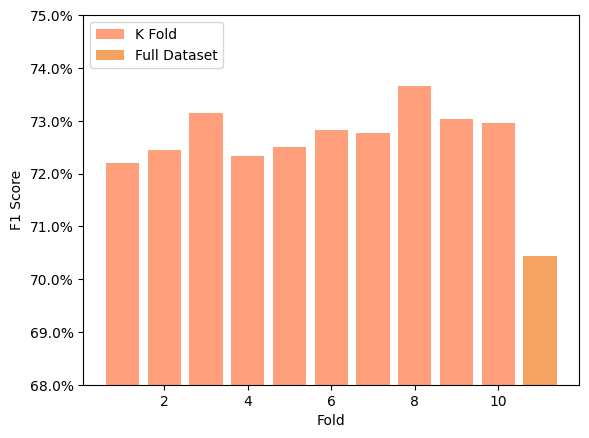

In [ ]:
x = [i+1 for i in range(len(k_fold_rfc))]
y = k_fold_mlp
f1 = f1_score(y_test,y_pred,average="weighted")

fig, ax=plt.subplots()

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylim(0.68,0.75)

ax.bar(x,y,label='K Fold',color='coral',alpha=0.75)
ax.bar(11,f1,label='Full Dataset',color='sandybrown')

plt.legend(loc='upper left')


plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.show()

**Confusion Matrix**

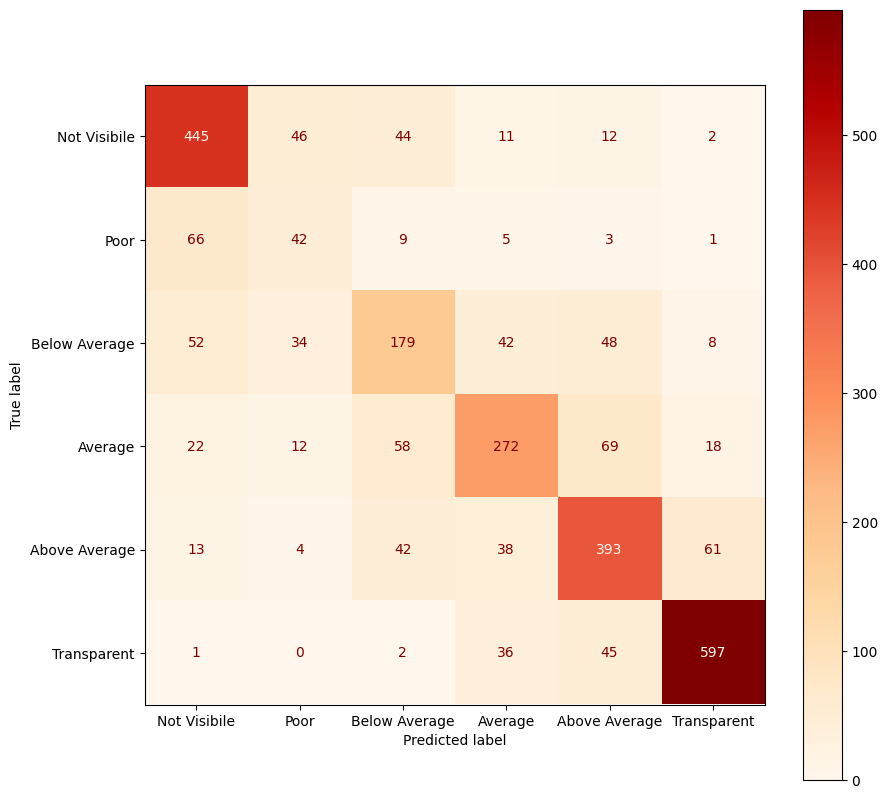

In [ ]:
#Fig 18
labels = ["Not Visibile","Poor","Below Average","Average","Above Average","Transparent"]
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax,cmap="OrRd")
plt.show()

#**Testing Different Pre-Processing**

##Different Pre-Processing Methods

In [ ]:
def no_upsampling_no_pca(model):
  #Train Test Split
  X_train, X_test, y_train, y_test = train_test_split(
      attributes_normal,
      target.values,
      test_size=0.3,
      stratify=target.values,
      random_state=seed)
  #Train Model
  model.fit(X_train,y_train)
  #Get Predicted Values
  y_pred = model.predict(X_test)
  #Accuracy Score
  acc = metrics.accuracy_score(y_test, y_pred)
  return acc

In [ ]:
def no_upsampling_pca(model):
  #PCA
  pca = PCA(n_components = 10)
  attributes_pca = pca.fit_transform(attributes_normal)
  #Train Test Split
  X_train, X_test, y_train, y_test = train_test_split(
      attributes_pca,
      target.values,
      test_size=0.3,
      stratify=target.values,
      random_state=seed)
  #Train Model
  model.fit(X_train,y_train)
  #Get Predicted Values
  y_pred = model.predict(X_test)
  #Accuracy Score
  acc = metrics.accuracy_score(y_test, y_pred)
  return acc

In [ ]:
def upsampling_pca(model):
  #PCA
  pca = PCA(n_components = 10)
  attributes_pca = pca.fit_transform(attributes_normal)
  #Train Test Split
  X_train, X_test, y_train, y_test = train_test_split(
      attributes_pca,
      target.values,
      test_size=0.3,
      stratify=target.values,
      random_state=seed)
  #Upsample
  oversampler = RandomOverSampler(random_state=seed)
  X_train, y_train = oversampler.fit_resample(X_train, y_train)
  #Train Model
  model.fit(X_train,y_train)
  #Get Predicted Values
  y_pred = model.predict(X_test)
  #Accuracy Score
  acc = metrics.accuracy_score(y_test, y_pred)
  return acc

In [ ]:
def upsampling_no_pca(model):
  #Train Test Split
  X_train, X_test, y_train, y_test = train_test_split(
      attributes_normal,
      target.values,
      test_size=0.3,
      stratify=target.values,
      random_state=seed)
  #Upsample
  oversampler = RandomOverSampler(random_state=seed)
  X_train, y_train = oversampler.fit_resample(X_train, y_train)
  #Train Model
  model.fit(X_train,y_train)
  #Get Predicted Values
  y_pred = model.predict(X_test)
  #Accuracy Score
  acc = metrics.accuracy_score(y_test, y_pred)
  return acc

##Gradient Boost Methodologies

In [ ]:
gb_methodologies={}

In [ ]:
#Recreate Model
gb_methodologies_model = GradientBoostingClassifier(
    n_estimators=1000,
    max_depth = 5,
    random_state = seed,
    learning_rate=0.1,
    validation_fraction=0.1,
    n_iter_no_change=10,
    min_samples_split=50,
    min_samples_leaf=50)
#Store Accuracy
gb_methodologies["No Upsampling No PCA"] = no_upsampling_no_pca(gb_methodologies_model)
gb_methodologies

In [ ]:
#Recreate Model
gb_methodologies_model = GradientBoostingClassifier(
    n_estimators=1000,
    max_depth = 5,
    random_state = seed,
    learning_rate=0.1,
    validation_fraction=0.1,
    n_iter_no_change=10,
    min_samples_split=50,
    min_samples_leaf=50)

#Store Accuracy Results
gb_methodologies["No Upsampling PCA"] = no_upsampling_pca(gb_methodologies_model)
gb_methodologies

{'No Upsampling No PCA': 0.7364568081991215,
 'No Upsampling PCA': 0.6599560761346999}

In [ ]:
#Recreate Model
gb_methodologies_model = GradientBoostingClassifier(
    n_estimators=1000,
    max_depth = 5,
    random_state = seed,
    learning_rate=0.1,
    validation_fraction=0.1,
    n_iter_no_change=10,
    min_samples_split=50,
    min_samples_leaf=50)

#Store Accuracy Results
gb_methodologies["Upsampling PCA"] = upsampling_pca(gb_methodologies_model)
gb_methodologies

{'No Upsampling No PCA': 0.7364568081991215,
 'No Upsampling PCA': 0.6599560761346999,
 'Upsampling PCA': 0.6570278184480234}

In [ ]:
#Recreate Model
gb_methodologies_model = GradientBoostingClassifier(
    n_estimators=1000,
    max_depth = 5,
    random_state = seed,
    learning_rate=0.1,
    validation_fraction=0.1,
    n_iter_no_change=10,
    min_samples_split=50,
    min_samples_leaf=50)

#Store Accuracy Results
gb_methodologies["Upsampling No PCA"] = upsampling_no_pca(gb_methodologies_model)
gb_methodologies

{'No Upsampling No PCA': 0.7364568081991215,
 'No Upsampling PCA': 0.6599560761346999,
 'Upsampling PCA': 0.6570278184480234,
 'Upsampling No PCA': 0.732796486090776}

##Random Forest Methodologies

In [ ]:
rfc_methodologies={}

In [ ]:
#Recreate Model
rfc_methodologies_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,max_features='sqrt',
    n_estimators=300,
    random_state=seed)

#Store Accuracy Results
rfc_methodologies["No Upsampling No PCA"] = no_upsampling_no_pca(rfc_methodologies_model)
rfc_methodologies

{'No Upsampling No PCA': 0.5607613469985359}

In [ ]:
#Recreate Model
rfc_methodologies_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,max_features='sqrt',
    n_estimators=300,
    random_state=seed)

#Store Accuracy Results
rfc_methodologies["No Upsampling PCA"] = no_upsampling_pca(rfc_methodologies_model)
rfc_methodologies

{'No Upsampling No PCA': 0.5607613469985359,
 'No Upsampling PCA': 0.5453879941434846}

In [ ]:
#Recreate Model
rfc_methodologies_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,max_features='sqrt',
    n_estimators=300,
    random_state=seed)

#Store Accuracy Results
rfc_methodologies["Upsampling PCA"] = upsampling_pca(rfc_methodologies_model)
rfc_methodologies

{'No Upsampling No PCA': 0.5607613469985359,
 'No Upsampling PCA': 0.5453879941434846,
 'Upsampling PCA': 0.5336749633967789}

In [ ]:
#Recreate Model
rfc_methodologies_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,max_features='sqrt',
    n_estimators=300,
    random_state=seed)

#Store Accuracy Results
rfc_methodologies["Upsampling No PCA"] = upsampling_no_pca(rfc_methodologies_model)
rfc_methodologies

{'No Upsampling No PCA': 0.5607613469985359,
 'No Upsampling PCA': 0.5453879941434846,
 'Upsampling PCA': 0.5336749633967789,
 'Upsampling No PCA': 0.5677159590043924}

##Multilayer Perceptron Methodologies

In [ ]:
mlp_methodologies = {}

In [ ]:
#Recreate Model
mlp_methodologies_model = MLPClassifier(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    solver='adam',
    max_iter=1000,
    early_stopping = True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=seed
    )

#Store Accurracy
mlp_methodologies["No Upsampling No PCA"] =  no_upsampling_no_pca(mlp_methodologies_model)
mlp_methodologies

{'No Upsampling No PCA': 0.7093704245973645}

In [ ]:
#Recreate Model
mlp_methodologies_model = MLPClassifier(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    solver='adam',
    max_iter=1000,
    early_stopping = True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=seed
    )

#Store Accurracy

mlp_methodologies["Upsampling No PCA"] =  upsampling_no_pca(mlp_methodologies_model)
mlp_methodologies

{'No Upsampling No PCA': 0.7093704245973645,
 'Upsampling No PCA': 0.705710102489019}

##**Different Methodologies Visualization**

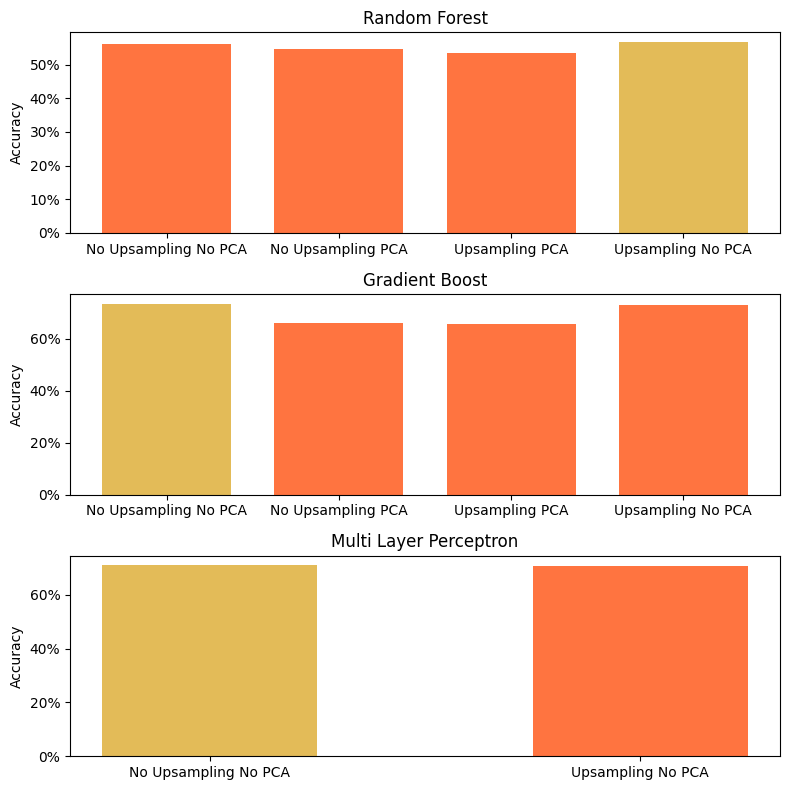

In [ ]:
fig, ax=plt.subplots(3,1,figsize=(8,8))

for key,value in rfc_methodologies.items():
  if key == "Upsampling No PCA":
    colors="goldenrod"
  else:
    colors="orangered"

  ax[0].bar(key,value,label='Model',color=colors,alpha=0.75,width=0.75)
  ax[0].yaxis.set_major_formatter(PercentFormatter(1))

for key,value in gb_methodologies.items():
  if key == "No Upsampling No PCA":
    colors="goldenrod"
  else:
    colors="orangered"

  ax[1].bar(key,value,label='Model',color=colors,alpha=0.75,width=0.75)
  ax[1].yaxis.set_major_formatter(PercentFormatter(1))

for key,value in mlp_methodologies.items():
  if key == "No Upsampling No PCA":
    colors="goldenrod"
  else:
    colors="orangered"

  ax[2].bar(key,value,label='Model',color=colors,alpha=0.75,width=0.5)
  ax[2].yaxis.set_major_formatter(PercentFormatter(1))

ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Accuracy")
ax[2].set_ylabel("Accuracy")

ax[0].set_title("Random Forest")
ax[1].set_title("Gradient Boost")
ax[2].set_title('Multi Layer Perceptron')

plt.tight_layout()

#**Real World Simulations**

In [ ]:
#Recreate Model
rfc_simulation = RandomForestClassifier(
    class_weight='balanced',
    max_depth=5,max_features='sqrt',
    n_estimators=300,
    random_state=seed)

rfc_accuracy = upsampling_pca(rfc_simulation)
rfc_accuracy

0.5336749633967789

In [ ]:
#Recreate Model
gb_simulation = GradientBoostingClassifier(
    n_estimators=1000,
    max_depth = 5,
    random_state = seed,
    learning_rate=0.1,
    validation_fraction=0.1,
    n_iter_no_change=10,
    min_samples_split=50,
    min_samples_leaf=50)

gb_accuracy = upsampling_pca(gb_simulation)
gb_accuracy

0.6570278184480234

In [ ]:
#Recreate Model
mlp_simulation = MLPClassifier(
    hidden_layer_sizes=(256,128,64),
    activation='relu',
    solver='adam',
    max_iter=1000,
    early_stopping = True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=seed
    )

mlp_accuracy = upsampling_no_pca(mlp_simulation)
mlp_accuracy

0.705710102489019

In [ ]:
df_real_world = pd.read_csv('/content/transparency_testing.csv')
drop_columns = ['transparency_forecast (0-5)']
attributes = df_real_world.drop(columns=drop_columns)
target = df_real_world ["transparency_forecast (0-5)"]
scaler = MinMaxScaler()
attributes_normal = scaler.fit_transform(attributes.values)

In [ ]:
#PCA
pca = PCA(n_components = 10)
attributes_pca = pca.fit_transform(attributes_normal)
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    attributes_pca,
    target.values,
    test_size=0.3,
    stratify=target.values,
    random_state=seed)

#Upsample
oversampler = RandomOverSampler(random_state=seed)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

#Make Prediction on New Dataset
y_pred = rfc_simulation.predict(X_test)
#Measure Accuracy of New Prediction
rfc_accuracy_rw = metrics.accuracy_score(y_test, y_pred)
rfc_accuracy_rw

0.2777777777777778

In [ ]:
#PCA
pca = PCA(n_components = 10)
attributes_pca = pca.fit_transform(attributes_normal)
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    attributes_pca,
    target.values,
    test_size=0.3,
    stratify=target.values,
    random_state=seed)
#Upsample
oversampler = RandomOverSampler(random_state=seed)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

#Make Prediction on New Dataset
y_pred = gb_simulation.predict(X_test)
#Measure Accuracy of New Prediction

gb_accuracy_rw = metrics.accuracy_score(y_test, y_pred)
gb_accuracy_rw

0.26851851851851855

In [ ]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    attributes_normal,
    target.values,
    test_size=0.3,
    stratify=target.values,
    random_state=seed)

#Upsample
oversampler = RandomOverSampler(random_state=seed)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

#Make Prediction on New Dataset
y_pred = mlp_simulation.predict(X_test)
#Measure Accuracy of New Prediction

mlp_accuracy_rw = metrics.accuracy_score(y_test, y_pred)
mlp_accuracy_rw

0.05555555555555555

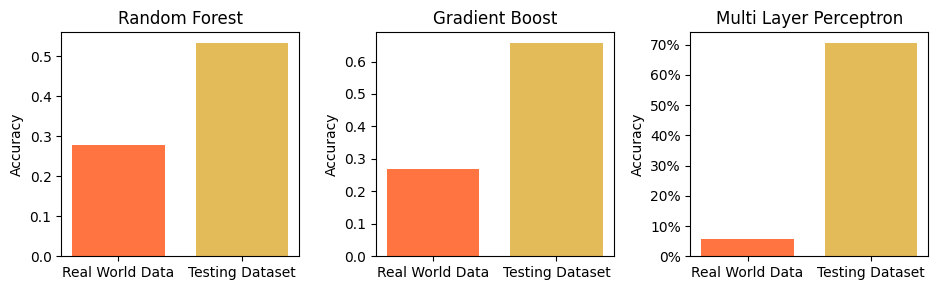

In [ ]:
fig, ax=plt.subplots(1,3,figsize=(9.5,3))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax[0].bar("Real World Data",rfc_accuracy_rw,label='Model',color='orangered',alpha=0.75,width=0.75)
ax[0].bar("Testing Dataset",rfc_accuracy,label='Model',color='goldenrod',alpha=0.75,width=0.75)

ax[1].bar("Real World Data",gb_accuracy_rw,label='Model',color='orangered',alpha=0.75,width=0.75)
ax[1].bar("Testing Dataset",gb_accuracy,label='Model',color='goldenrod',alpha=0.75,width=0.75)

ax[2].bar("Real World Data",mlp_accuracy_rw,label='Model',color='orangered',alpha=0.75,width=0.75)
ax[2].bar("Testing Dataset",mlp_accuracy,label='Model',color='goldenrod',alpha=0.75,width=0.75)

ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Accuracy")
ax[2].set_ylabel("Accuracy")

ax[0].set_title("Random Forest")
ax[1].set_title("Gradient Boost")
ax[2].set_title('Multi Layer Perceptron')

plt.tight_layout()